In [1]:
import pycbc
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#source activate /Users/brettlv/anaconda3/envs/ipykernel_py2
#source deactivate /Users/brettlv/anaconda3/envs/ipykernel_py2
#source activate /Users/brettlv/anaconda3/envs/ipykernel_py2

!python -V
!python2 -V
!python3 -V
!pip -V
!pip2 -V
!pip3 -V

Python 2.7.13 :: Anaconda 4.3.0 (x86_64)
Python 2.7.13 :: Anaconda 4.3.0 (x86_64)
Python 3.6.0 :: Anaconda custom (x86_64)
pip 18.0 from /Users/brettlv/anaconda2/lib/python2.7/site-packages/pip (python 2.7)
pip 18.0 from /Users/brettlv/anaconda2/lib/python2.7/site-packages/pip (python 2.7)
pip 18.0 from /Users/brettlv/anaconda3/lib/python3.6/site-packages/pip (python 3.6)


In [3]:
import sys
!{sys.executable} -m pip install lalsuite pycbc
#import gwpy
#!python -c "import gwpy; print(gwpy.__version__)"


In [3]:
# Read in the data around GW150914
from pycbc.catalog import Merger
import pylab

m = Merger('GW150914')
data = {}
for ifo in ['H1', 'L1']:
    data[ifo] = m.strain(ifo)
   

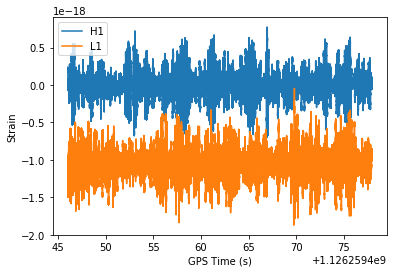

In [4]:
for ifo in data:
    pylab.plot(data[ifo].sample_times, data[ifo], label=ifo)

pylab.ylabel('Strain')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()


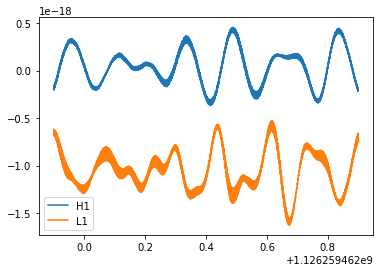

In [5]:
for ifo in data:
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = data[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.legend()
pylab.show()


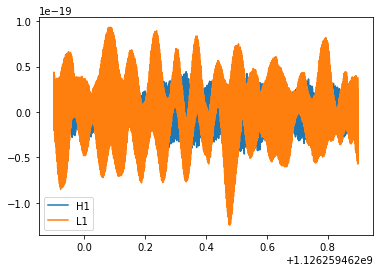

In [6]:
for ifo in data:
    # Apply a highpass filter to the data. This suppresses the low
    # frequency content of the data. We choose here a finite-impulse-response (FIR).
    # Options
    # 1) highpass frequency
    # 2) half sample length of highpass filter 
    #(higher value will give less ripple in passband)
    high_data = data[ifo].highpass_fir(15, 512) # Highpass point is 15 Hz
    
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = high_data.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)
pylab.legend()
pylab.show()

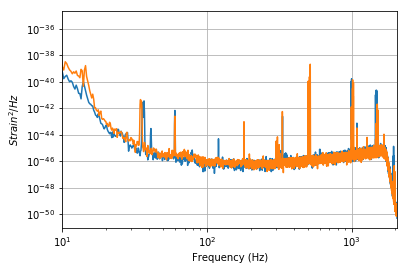

In [7]:
for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    
    # Note that the psd is a FrequencySeries!
    pylab.loglog(psd.sample_frequencies, psd)
    
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.xlim(10, 2048)
pylab.show()

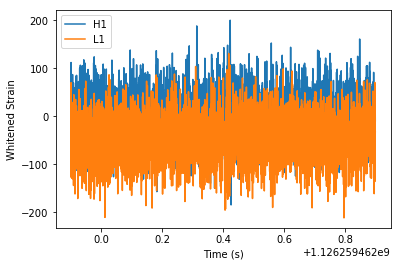

In [8]:
# Whiten the data
whitened = {}

for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

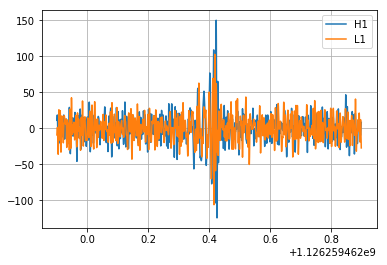

In [9]:
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    zoom = bpsd.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

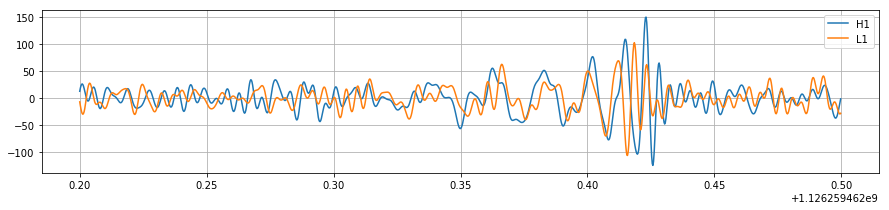

In [10]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

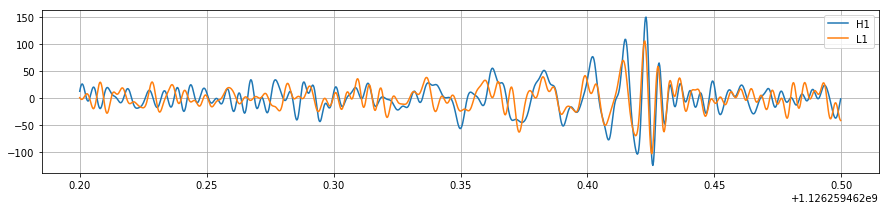

In [11]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    # A later tutorial will show how to estimate this alignment more precisely.
    if ifo == 'L1':
        bpsd.roll(int(bpsd.sample_rate * .007))
        bpsd *= -1
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

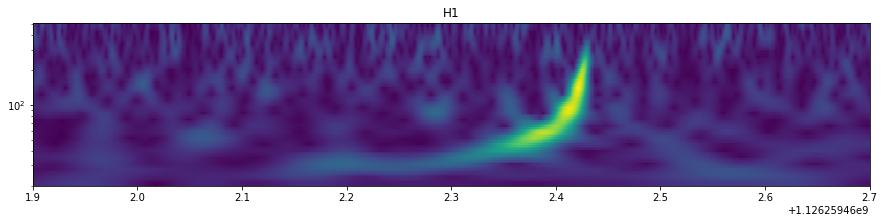

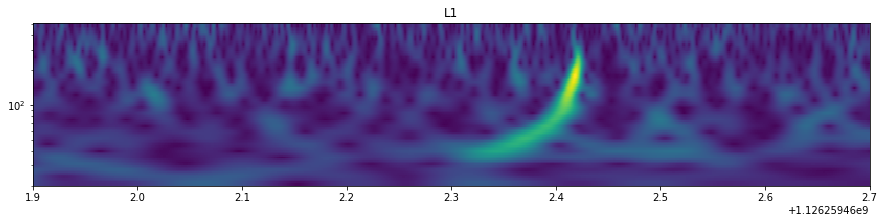

In [12]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(m.time - 5, m.time + 5)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=100,
                                                qrange=(8, 8),
                                                frange=(20, 512),
                                         )
    pylab.figure(figsize=[15, 3])
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(m.time - 0.5, m.time + 0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()
    
    

In [ ]:
!find / -name gcc -print 2>/dev/null
!find / -name g++ -print 2>/dev/null

In [ ]:
find / -name gcc -print 2>/dev/null
find / -name g++ -print 2>/dev/null

In [ ]:
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
for apx in ['SEOBNRv4','IMRPhenomC']:
    hp,hc=get_td_waveform(approximant=apx,mass1=10,mass2=10,spin1z=0.9,spin2z=0.4,delta_t=1.0/4096,f_lower=40,distance = 100 )
    plt.plot(hp.sample_times,hp,label=apx)

plt.xlabel("Time(s)")
plt.ylabel("Strain")
plt.legend()
plt.show()


hp_merge = hp[len(hp)-400:]
hc_merge = hc[len(hc)-400:]
plt.plot(hp_merge.sample_times, hp_merge, label='Plus polarization')
plt.plot(hc_merge.sample_times, hc_merge, label='Cross polarization')
plt.legend()

plt.xlabel('Time/s')
plt.ylabel('Strain')
plt.show()

In [ ]:
from pycbc.waveform import get_td_waveform 
a=10
b=a*0.618
plt.figure(figsize=(a,b))
for apx in ['SEOBNRv4','IMRPhenomC']:
    hp,hc=get_td_waveform(approximant=apx,mass1=10,mass2=10,spin1z=0.9,spin2z=0.4,delta_t=1.0/4096,f_lower=40)
    plt.plot(hp.sample_times,hp,label=apx)
plt.ylabel("Strain")
plt.xlabel("Time(s)")
plt.legend()
plt.show()

In [ ]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()